<a href="https://colab.research.google.com/github/SriramyaK/Data-Visualizations/blob/master/Supply_vs_Demand_housing_prices_US.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Find publicly available data for key supply-demand factors that influence US home prices. Then, build a data science model that explains how these factors impacted home prices over the last 20 years.** 


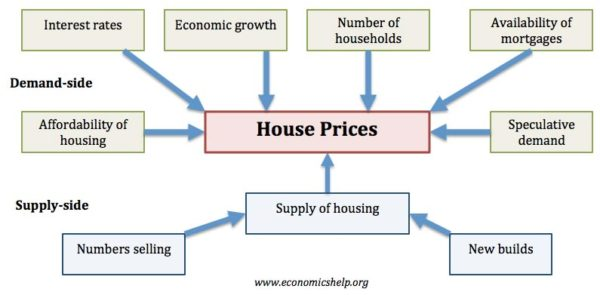


In [204]:
import pandas as pd
import matplotlib.pyplot as plt # Plotting library
import seaborn as sns # data visualization library
import datetime
%matplotlib inline
sns.set_style('darkgrid')
housing = pd.read_csv("Supply_and_demand.csv",parse_dates=True)
housing.head()
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Year                       241 non-null    object 
 1   HPI                        241 non-null    float64
 2   Unemployment Rate          241 non-null    float64
 3   GDP                        241 non-null    float64
 4   Inventory                  241 non-null    float64
 5   Consumer Confidence Index  241 non-null    float64
 6   Housing Starts             241 non-null    float64
 7   Permits_cust               241 non-null    float64
 8   Population                 241 non-null    float64
 9   Interest Rates             241 non-null    float64
 10  Mortgage Rate              241 non-null    float64
 11  Stock Market               241 non-null    float64
 12  Consumer Credit            241 non-null    float64
dtypes: float64(12), object(1)
memory usage: 25.7+ KB


In [205]:
housing['Year_parsed'] =  pd.to_datetime(housing['Year'])
housing['Year'] = housing['Year_parsed'].dt.year
housing['Month'] = housing['Year_parsed'].dt.month
housing.drop(columns=['Year_parsed'],inplace=True)

In [206]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Year                       241 non-null    float64
 1   HPI                        241 non-null    float64
 2   Unemployment Rate          241 non-null    float64
 3   GDP                        241 non-null    float64
 4   Inventory                  241 non-null    float64
 5   Consumer Confidence Index  241 non-null    float64
 6   Housing Starts             241 non-null    float64
 7   Permits_cust               241 non-null    float64
 8   Population                 241 non-null    float64
 9   Interest Rates             241 non-null    float64
 10  Mortgage Rate              241 non-null    float64
 11  Stock Market               241 non-null    float64
 12  Consumer Credit            241 non-null    float64
 13  Month                      241 non-null    float64

In [207]:
housing.dropna(inplace=True)

In [208]:
housing.columns

Index(['Year', 'HPI', 'Unemployment Rate', 'GDP', 'Inventory ',
       'Consumer Confidence Index', 'Housing Starts', 'Permits_cust',
       'Population', 'Interest Rates', 'Mortgage Rate', 'Stock Market',
       'Consumer Credit', 'Month'],
      dtype='object')

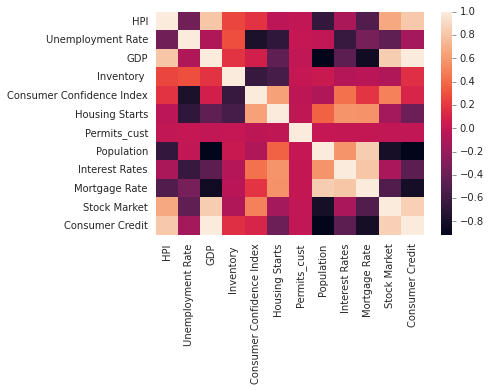

In [209]:
attributes = ['HPI', 'Unemployment Rate', 'GDP', 'Inventory ',
       'Consumer Confidence Index', 'Housing Starts', 'Permits_cust',
       'Population', 'Interest Rates', 'Mortgage Rate', 'Stock Market',
       'Consumer Credit',]
numeric_analysis = housing[attributes].corr()
sns.heatmap(numeric_analysis)

In [210]:
y = housing['HPI']
x = housing.drop(columns='HPI')

In [211]:
x.shape, y.shape

((241, 13), (241,))

In [212]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=1)

In [213]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((192, 13), (49, 13), (192,), (49,))

In [214]:
trainX = pd.DataFrame(x_train)
trainX['target'] = y_train

testX = pd.DataFrame(x_test)
testX['target'] = y_test

In [215]:
trainX.to_csv('housing_train.csv')
testX.to_csv('housing_test.csv')

In [216]:
%%writefile script.py

import argparse
import os

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.externals import joblib
from sklearn.metrics import explained_variance_score, r2_score
import matplotlib.pyplot as plt

# inference functions ---------------
def model_fn(model_dir):
    clf = joblib.load(os.path.join(model_dir, "model.joblib"))
    return clf

if __name__ =='__main__':

    print('extracting arguments')
    parser = argparse.ArgumentParser()

    # hyperparameters sent by the client are passed as command-line arguments to the script.
    # to simplify the demo we don't use all sklearn RandomForest hyperparameters
    parser.add_argument('--n-estimators', type=int, default=100)
    parser.add_argument('--max_leaf_nodes', type=int, default=10)
    

    # Data, model, and output directories
    parser.add_argument('--model-dir', type=str, default=os.environ.get('MODEL_DIR'))
    parser.add_argument('--train', type=str, default=os.environ.get('CHANNEL_TRAIN'))
    parser.add_argument('--test', type=str, default=os.environ.get('CHANNEL_TEST'))
    parser.add_argument('--train-file', type=str, default='housing_train.csv')
    parser.add_argument('--test-file', type=str, default='housing_test.csv')
    
    args, _ = parser.parse_known_args()
    
    print('reading data')
    train_df = pd.read_csv(os.path.join(args.train, args.train_file))
    test_df = pd.read_csv(os.path.join(args.test, args.test_file))

    print('building training and testing datasets')
    
    X_train = train_df
    X_test = test_df
    y_train = train_df['target']
    y_test = test_df['target']
    
    # train
    print('training model')
    model = RandomForestRegressor(
        n_estimators=args.n_estimators,
        max_leaf_nodes =args.max_leaf_nodes,
        n_jobs=-1)
    
    model.fit(X_train, y_train)
     
    # persist model
    path = os.path.join(args.model_dir, "model.joblib")
    joblib.dump(model, path)
    print('model persisted at ' + path)
   
    # print explained_variance_score 
    print('validating model')
    predictions = model.predict(X_test)

    print(predictions)
    print("Explained Variance Score is " + str(explained_variance_score(y_test, predictions).round(2)))
    print("R2 score : %.2f" % r2_score(y_test,predictions))

Overwriting script.py


In [217]:
! python script.py --n-estimators 100 \
                   --max-leaf-nodes 8 \
                   --model-dir ./ \
                   --train ./ \
                   --test ./ \

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
extracting arguments
reading data
building training and testing datasets
training model
model persisted at ./model.joblib
validating model
[175.37761672 206.48041274 185.70529735 146.8927722  180.87892109
 196.23366703 156.50700444 169.91468421 165.24945242 106.04690907
 201.62409115 205.50594705 148.92842333 150.92874791 163.18831159
 206.88131326 168.41650614 147.76534259 117.60260444 206.88131326
 200.90430894 119.63344354 177.24129291 169.31644464 148.92842333
 148.92842333 152.58271081 182.87050978 133.94631556 190.45096932
 182.87050978 137.74398

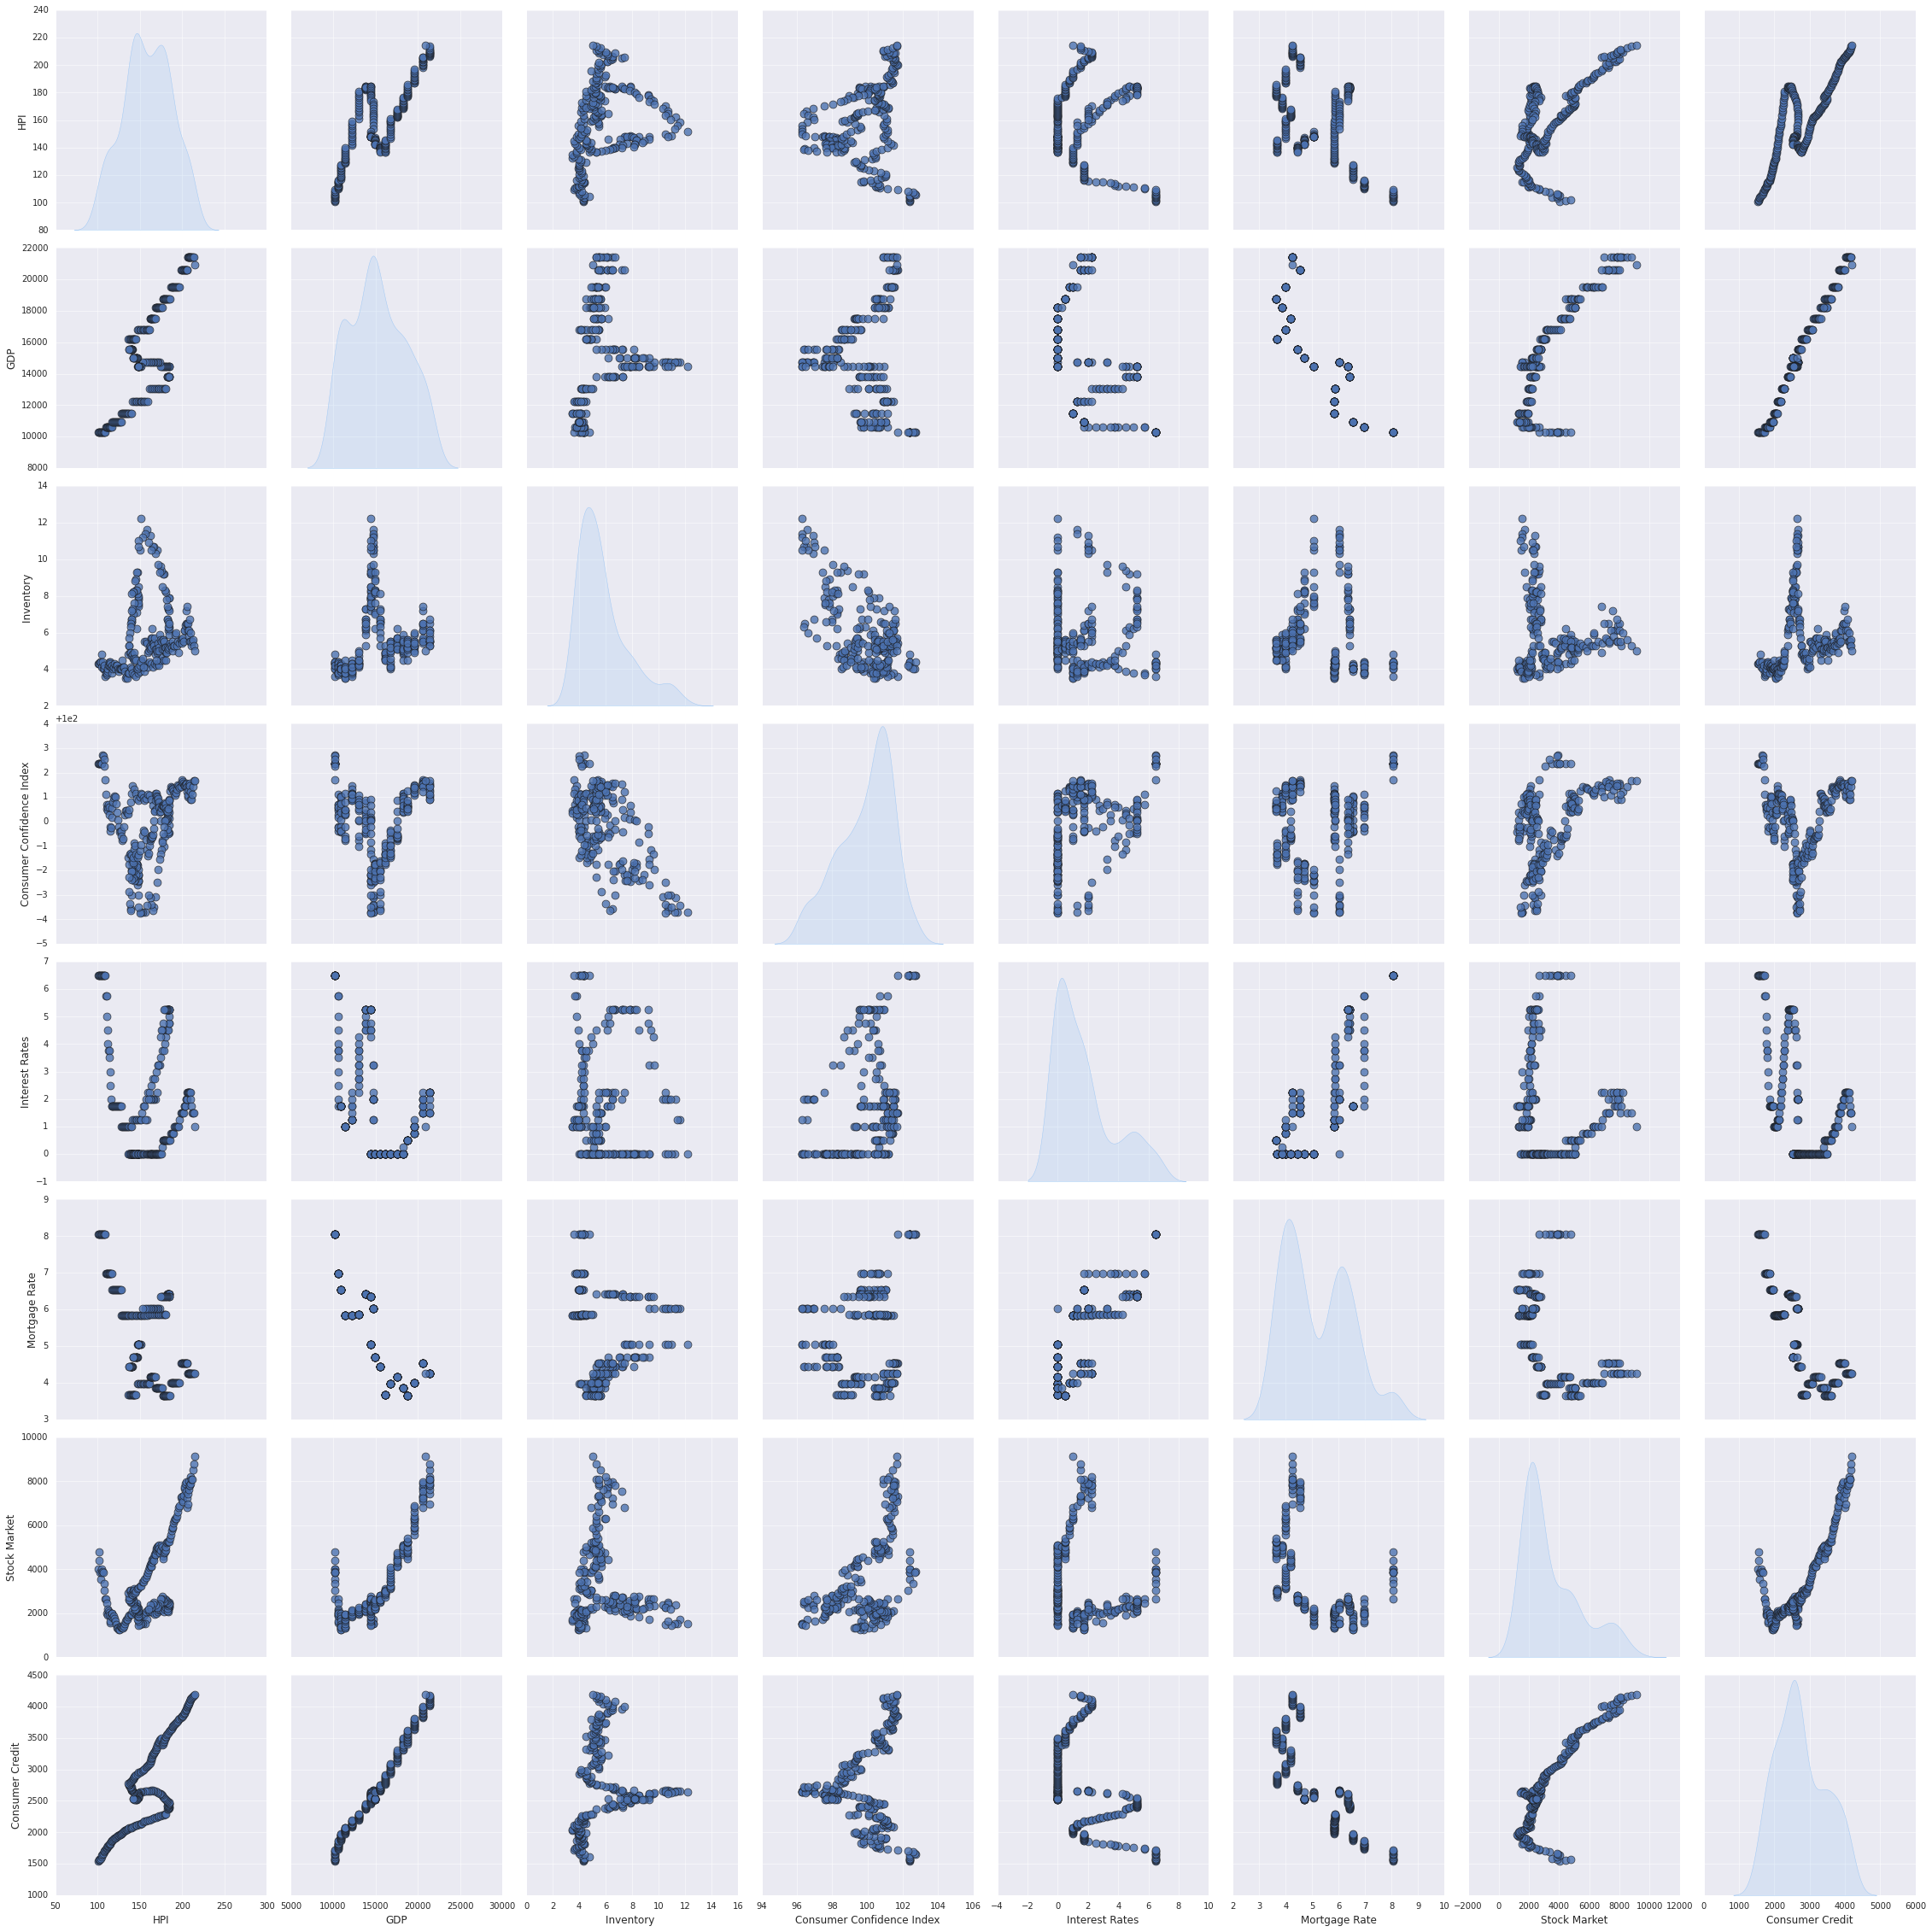

In [218]:
import warnings
warnings.simplefilter("ignore", UserWarning)

attributes = ['HPI', 'GDP', 'Inventory ',
       'Consumer Confidence Index', 
       'Interest Rates', 'Mortgage Rate', 'Stock Market',
       'Consumer Credit']

# Supply Demand Facotors impacting HPI
sns.pairplot(housing[attributes], diag_kind = 'kde', palette ="Set2",
             plot_kws = {'alpha': 0.8, 's': 80, 'edgecolor': 'k'},
             height = 4)